In [1]:
import pickle, os
import networkx as nx

In [8]:
#Load and build graph
with open('./processed_data/connectivity.pkl', 'rb') as handle:
    France = pickle.load(handle)
    
France = nx.Graph(France)

In [9]:
#Load and add attributes dict
with open('./processed_data/departments.pkl', 'rb') as handle:
    France_atts = pickle.load(handle)

In [24]:
?nx.set_node_attributes

In [25]:
#Set department name
nx.set_node_attributes(France,
            {key:value['name'] for key, value in France_atts.items()},
            'name')

In [28]:
#Set department capital
nx.set_node_attributes(France,
            {key:value['capital'] for key, value in France_atts.items()},
            'capital')

In [29]:
#Set department population
nx.set_node_attributes(France,
            {key:value['population'] for key, value in France_atts.items()},
            'population')

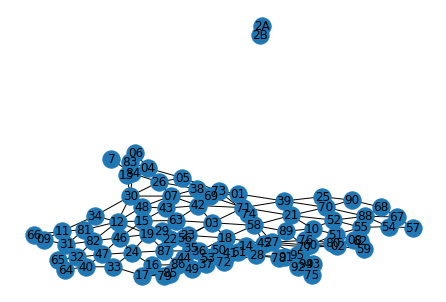

In [30]:
nx.draw(France, with_labels=True)

In [46]:
#Save pickle
nx.write_gpickle(France, path='./processed_data/France_grapg.pkl')

In [47]:
#Save GML graph
nx.write_gml(France, path='./processed_data/France_grapg.gml')